<a href="https://colab.research.google.com/github/lzumta/Reinforcement-Learning-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

## Optimal Agent
To see our best performing agent, go to the end of this notebook. The agent wins in more than 99 % of the games!

In [1]:
# Import 

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import time
from statistics import mean

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.



In [2]:
## INITIALISE THE ENVIRONMENT
size_board = 4
env=Chess_Env(size_board)
np.random.seed(42)


In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)
print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('-----------------')
    print(X)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[3 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 1 0]]
check?  0
dofk2  2

[[0 0 0 0]
 [3 0 0 0]
 [0 0 0 0]
 [0 0 1 2]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 2]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
check?  0
dofk2  3

[[0 0 3 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 2]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 2 0]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 
S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):

    if n % 500 == 0 and n != 0:
      print('Average reward:',np.mean(R_save_random[n-500:n]),'Number of steps: ',np.mean(N_moves_save_random[n-500:n]))
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE

    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)
            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))


Average reward: 0.212 Number of steps:  7.252
Random_Agent, Average reward: 0.189 Number of steps:  7.137


In [5]:
# moving average
def moving_average(a, n):
    """ A function to compute moving averages"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
#print(moving_average(R_save, n=500))

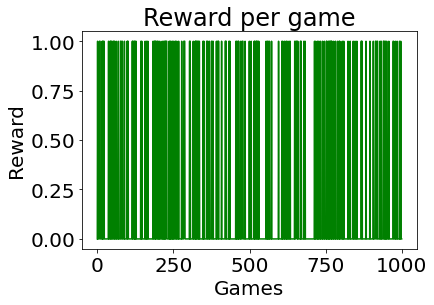

In [6]:
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))

plt.plot(np.arange(0,1000), R_save_random, 'g')
plt.title("Reward per game")
plt.xlabel("Games")
plt.ylabel("Reward")
plt.show()

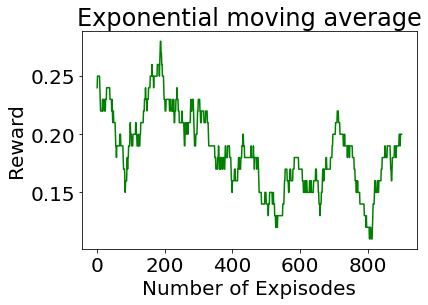

In [7]:
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,1000-99), moving_average(R_save_random, n=100), 'g')
plt.title("Exponential moving average")
plt.xlabel("Number of Expisodes")
plt.ylabel("Reward")
plt.show()

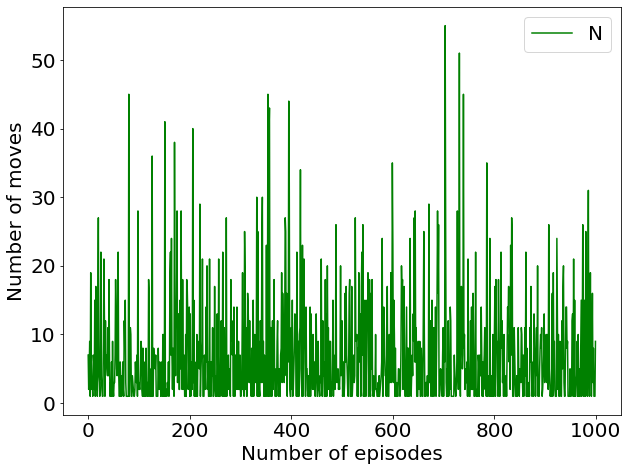

In [8]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,7.5)

plt.plot(np.arange(0,1000),N_moves_save_random,'g')
plt.legend('Number of moves')
plt.xlabel('Number of episodes')
plt.ylabel('Number of moves')
plt.show()

In [9]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE THE NEURAL NETWORK...
class Neural_Netork(nn.Module):
    def __init__(self):
        super(Neural_Netork, self).__init__()
        self.fc1 = nn.Linear(N_in, N_h)
        self.out = nn.Linear(N_h, N_a)
        
        # *** uncomment the following two lines to reproduce results of task E, weight initialization with xavier ***
        #torch.nn.init.xavier_uniform_(self.fc1.weight)
        #torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        action = self.out(x)
        return action


In [10]:
class ChessAgent():
    def __init__(self):
        super(ChessAgent, self).__init__()
        self.policy_net = Neural_Netork()
        self.target_net = Neural_Netork()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory_q = np.zeros((memory_size, N_in * 2 + 2))
        self.memory_sarsa = np.zeros((memory_size, N_in * 2 + 4))
        
        self.optimizer = torch.optim.SGD(self.policy_net.parameters(), lr=eta)
        self.loss_function = nn.MSELoss()

    def choose_action(self, state, allowed_a, epsilon_f):
        """
        
        :param state: np.array the actual state of the board
        :param allowed_a: np.array with intgers 0 or 1 marking if the action is allowed (1) not allowed (0)
        :param epsilon_f: float parameter for greedy policy
        :return: int index of chosen action
        """
        state = torch.unsqueeze(torch.FloatTensor(state), 0) # get a 1D array
        a,_=np.where(allowed_a==1) # get indexes of allowed actions
        if np.random.random() > epsilon_f: # greedy policy
            # Exploitation
            action_value = self.policy_net.forward(state)
            actions = torch.detach(action_value).numpy()
            actions = [actions[0][i] for i in a]
            action = np.argmax(actions)
            action = a[action]
        else: # random policy
            # Exploration
            action = np.random.permutation(a)[0]
        return action


    def store_transition_q(self, state, action, reward, next_state):
        """
        store a transition into memory
        :param state: np.array the actual state of the board
        :param action1: int the action taken
        :param reward: int reward gained with state and action 1
        :param next_state: np.array the next state of the board
        :param done: int if the game has finished (1 finished, 0 not finished)
        """
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % memory_size
        self.memory_q[index, :] = transition
        self.memory_counter += 1

    def store_transition_sarsa(self, state, action1, action2, reward, next_state, done):
        """
        store a transition into memory
        :param state: np.array the actual state of the board
        :param action1: int the action taken
        :param action2: int the next action
        :param reward: int reward gained with state and action 1
        :param next_state: np.array the next state of the board
        :param done: int if the game has finished (1 finished, 0 not finished)
        """
        
        transition = np.hstack((state, [action1, action2, reward, done], next_state))
        index = self.memory_counter % memory_size
        self.memory_sarsa[index, :] = transition
        self.memory_counter += 1

    def train_q(self):
        """
        train the networks with q_learning
        """

        #update the parameters
        if self.learn_step_counter % 100 ==0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(memory_size, 32)
        batch_memory = self.memory_q[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :N_in])
        batch_action = torch.LongTensor(batch_memory[:, N_in:N_in+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, N_in+1:N_in+2])
        batch_next_state = torch.FloatTensor(batch_memory[:,-N_in:])

        #q_eval
        q_eval = self.policy_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + gamma * q_next.max(1)[0].view(32, 1)
        loss = self.loss_function(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def train_sarsa(self):
        """
        train the networks with sarsa
        """
        #update the parameters
        if self.learn_step_counter % 100 ==0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(memory_size, 32)
        batch_memory = self.memory_sarsa[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :N_in])
        batch_action1 = torch.LongTensor(batch_memory[:, N_in:N_in+1].astype(int))
        batch_action2 = torch.LongTensor(batch_memory[:, N_in+1:N_in+2].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, N_in+2:N_in+3])
        # batch_done = torch.FloatTensor(batch_memory[:, N_in+3:N_in+4])
        batch_next_state = torch.FloatTensor(batch_memory[:,-N_in:])

        # compute the loss
        q_eval = self.policy_net(batch_state).gather(1, batch_action1)          
        q_next = self.target_net(batch_next_state).gather(1, batch_action2)
        q_target = batch_reward + gamma * q_next
        loss = self.loss_function(q_eval, q_target)

        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Deep Q_Learning Implementation

In [11]:
# HYPERPARAMETERS USED FOR Q_LEARNING (FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
# *** beta and gamma values can be changed to reproduce results of task B ***
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
memory_size = 2000 # THE SIZE OF THE MEMORY
# *** reward_draw can be changed to -1 to reproduce results from task E ***
reward_draw = 0  # THE REWARD FOR A DRAW, YOU CAN CHANGE THIS TO REPRODUCE OUR RESULTS TO -1
reward_check = 1 # THE REWARD FOR A CHECK

In [12]:
# SAVING VARIABLES
R_save_q = np.zeros([N_episodes, 1])
N_moves_save_q = np.zeros([N_episodes, 1])
Training_time_per_episode_q = np.zeros([N_episodes, 1])

# PRINT AVERAGE REWARD EVERY NUMBER OF EPISODES
print_every = 500

In [13]:
agent_q = ChessAgent()

print(f"Average rewards for every {print_every} episodes:")
print('---------------------------------------')
for n in range(N_episodes):

    if n % print_every == 0 and n != 0:
      print('Average reward:',np.mean(R_save_q[n-print_every:n]),'Number of steps: ',np.mean(N_moves_save_q[n-print_every:n]), 'Training time: ',np.mean(Training_time_per_episode_q[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game(reward_draw=reward_draw, reward_check=reward_check)      ## INITIALISE GAME

    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
    
        action = agent_q.choose_action(X, allowed_a, epsilon_f)

        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action)
        agent_q.store_transition_q(X, action, R, X_next)

        if agent_q.memory_counter >= memory_size:
                agent_q.train_q()      

        ## THE EPISODE HAS ENDED, UPDATE   
        if Done==1:
          R_save_q[n]=np.copy(R)
          N_moves_save_q[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_q[n] = abs(start-end)/1000
          break

        # IF THE EPISODE IS NOT OVER, ADD REWARD
        else:
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    
           

Average rewards for every 500 episodes:
---------------------------------------
Average reward: 0.228 Number of steps:  7.574 Training time:  2.633949279785156e-05
Average reward: 0.328 Number of steps:  6.794 Training time:  2.784263372421265e-05
Average reward: 0.376 Number of steps:  4.504 Training time:  1.9673581600189205e-05
Average reward: 0.438 Number of steps:  3.908 Training time:  1.7652544975280757e-05
Average reward: 0.466 Number of steps:  3.376 Training time:  1.767758560180664e-05
Average reward: 0.436 Number of steps:  3.576 Training time:  2.1553828716278077e-05
Average reward: 0.478 Number of steps:  3.312 Training time:  2.2231728553771973e-05
Average reward: 0.482 Number of steps:  2.986 Training time:  2.149784851074219e-05
Average reward: 0.55 Number of steps:  3.178 Training time:  2.324119997024536e-05
Average reward: 0.52 Number of steps:  2.93 Training time:  2.863655662536621e-05
Average reward: 0.52 Number of steps:  3.08 Training time:  3.2270339965820314e

In [14]:
# Print average reward and average number of steps overall
print(f'Results over the whole Q_learning training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q), 'Average training time: ', np.mean(Training_time_per_episode_q))


Results over the whole Q_learning training with 100000 episodes:
Trained_Agent, Average reward: 0.65808 Number of steps:  1.99117 Average training time:  1.9930069930553434e-05


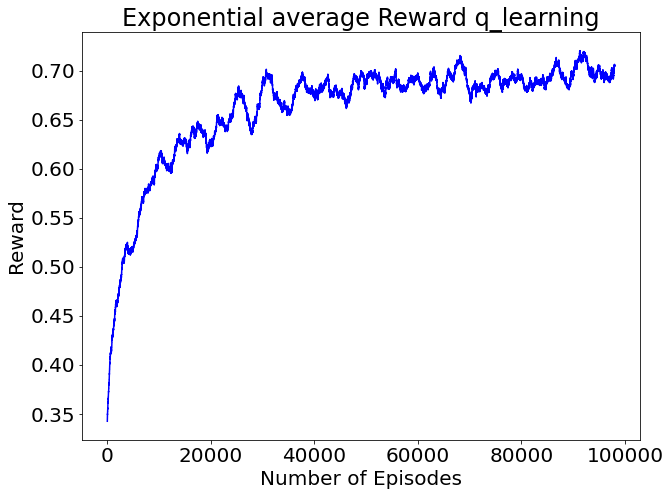

In [15]:
# Plot: Average reward exp
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_q, n=2000), 'b')
plt.title("Exponential average Reward q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.show()

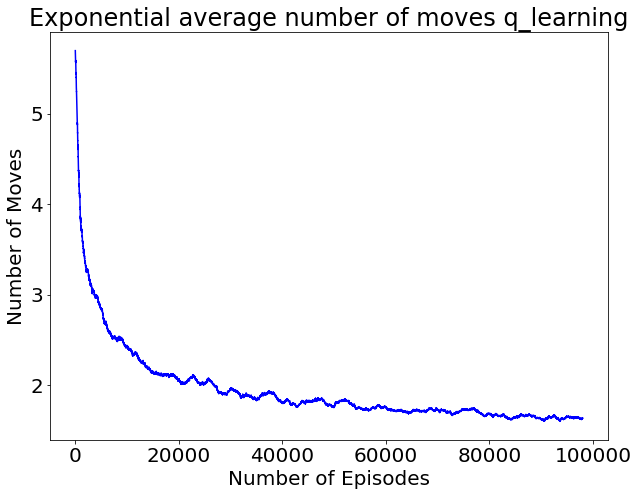

In [16]:
# Plot: number of moves
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(N_moves_save_q, n=2000), 'b')
plt.title("Exponential average number of moves q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Moves")
plt.show()

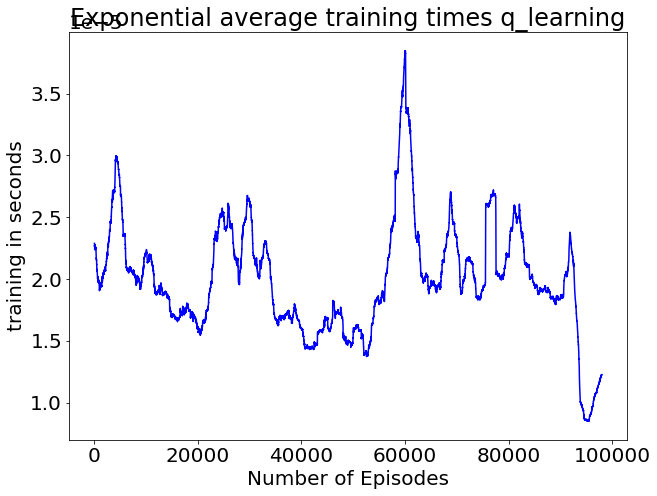

In [17]:
# Plot: training time
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(Training_time_per_episode_q, n=2000), 'b')
plt.title("Exponential average training times q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("training in seconds")
plt.show()

# Deep SARSA Implementation

In [18]:
# HYPERPARAMETERS USED FOR SARSA (FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
# *** beta and gamma values can be changed to reproduce results of task B ***
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
memory_size = 2000 # THE SIZE OF THE MEMORY
# *** reward_draw can be changed to -1 to reproduce results from task E ***
reward_draw = 0  # THE REWARD FOR A DRAW, YOU CAN CHANGE THIS TO REPRODUCE OUR RESULTS TO -1
reward_check = 1 # THE REWARD FOR A CHECK

In [19]:
# SAVING VARIABLES
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_save_sarsa = np.zeros([N_episodes, 1])
Training_time_per_episode_sarsa = np.zeros([N_episodes, 1])

# PRINT AVERAGE REWARD EVERY NUMBER OF EPISODES
print_every = 500

In [20]:

agent_sarsa = ChessAgent()

print(f"Average rewards for every {print_every} episodes:")
print('---------------------------------------')
for n in range(N_episodes):

    if n % print_every == 0 and n != 0:
      print('Average reward:',np.mean(R_save_sarsa[n-print_every:n]),'Number of steps: ',np.mean(N_moves_save_sarsa[n-print_every:n]), 'Training time: ',np.mean(Training_time_per_episode_sarsa[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game(reward_draw=reward_draw, reward_check=reward_check)      ## INITIALISE GAME

    action1 = agent_sarsa.choose_action(X, allowed_a, epsilon_f)

    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action1)

        if agent_sarsa.memory_counter >= memory_size:
              agent_sarsa.train_sarsa()  

        if Done==1: 
          action2 = 0  # just to add something to the memory       
          agent_sarsa.store_transition_sarsa(X, action1, action2, R, X_next, Done)
          R_save_sarsa[n]=np.copy(R)
          N_moves_save_sarsa[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa[n] = (abs(start-end)/1000)
          break
        
        action2 = agent_sarsa.choose_action(X_next, allowed_a_next, epsilon_f)
        
        agent_sarsa.store_transition_sarsa(X, action1, action2, R, X_next, Done)

       

        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
          R_save_sarsa[n]=np.copy(R)
          N_moves_save_sarsa[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa[n] = (abs(start-end)/1000)
          break

        # IF THE EPISODE IS NOT OVER, ADD REWARD
        else:
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        action1=np.copy(action2)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

Average rewards for every 500 episodes:
---------------------------------------
Average reward: 0.274 Number of steps:  7.142 Training time:  3.2001284599304194e-05
Average reward: 0.288 Number of steps:  5.816 Training time:  5.082926416397095e-05
Average reward: 0.324 Number of steps:  5.224 Training time:  5.103395318984985e-05
Average reward: 0.382 Number of steps:  4.422 Training time:  4.0824645996093756e-05
Average reward: 0.48 Number of steps:  4.116 Training time:  3.726078701019286e-05
Average reward: 0.488 Number of steps:  4.148 Training time:  3.7562126636505126e-05
Average reward: 0.502 Number of steps:  3.474 Training time:  3.142077827453613e-05
Average reward: 0.534 Number of steps:  2.94 Training time:  2.674089241027832e-05
Average reward: 0.49 Number of steps:  3.372 Training time:  2.818906831741333e-05
Average reward: 0.52 Number of steps:  3.066 Training time:  2.6431124687194826e-05
Average reward: 0.538 Number of steps:  2.982 Training time:  2.4576650619506838

In [21]:
# Print average reward and average number of steps overall
print(f'Results over the whole sarsa training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa), 'Average training time: ', np.mean(Training_time_per_episode_sarsa))

Results over the whole sarsa training with 100000 episodes:
Trained_Agent, Average reward: 0.68144 Number of steps:  2.19403 Average training time:  2.0535561263561248e-05


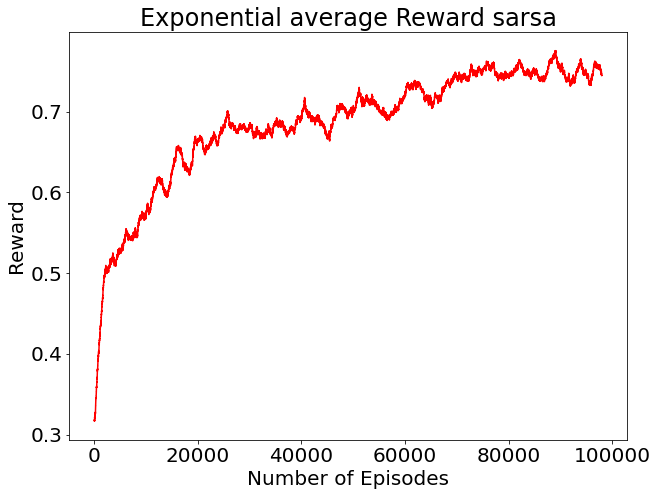

In [22]:
# Plot: Average reward exp
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_sarsa, n=2000), 'r')
plt.title("Exponential average Reward sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.show()

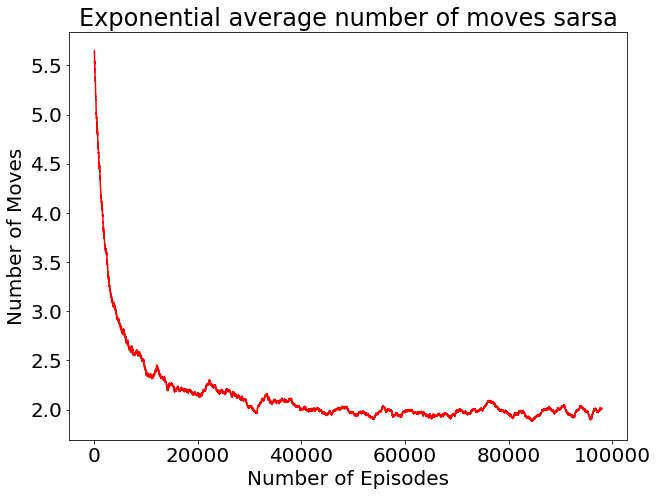

In [23]:
# Plot: number of moves
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(N_moves_save_sarsa, n=2000), 'r')
plt.title("Exponential average number of moves sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Moves")
plt.show()

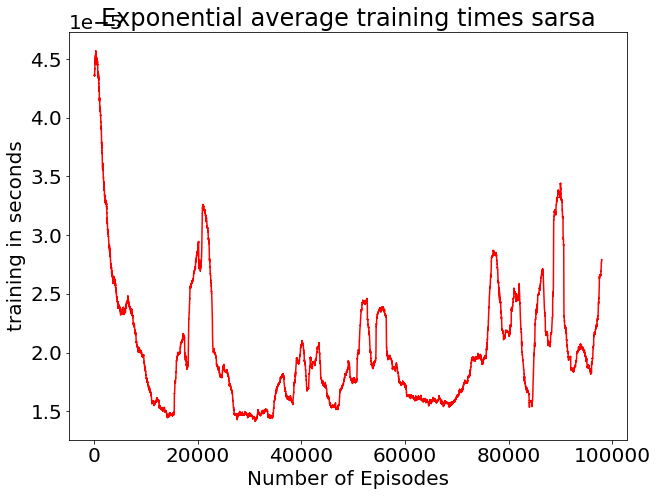

In [24]:
# Plot: training time
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(Training_time_per_episode_sarsa, n=2000), 'r')
plt.title("Exponential average training times sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("training in seconds")
plt.show()



# Deep Q_Learning vs SARS Comparision

In [25]:
# Print average reward and average number of steps overall
print(f'Results over the whole Q_learning training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q))

# Print average reward and average number of steps overall
print(f'Results over the whole SARSA training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))



Results over the whole Q_learning training with 100000 episodes:
Trained_Agent, Average reward: 0.65808 Number of steps:  1.99117
Results over the whole SARSA training with 100000 episodes:
Trained_Agent, Average reward: 0.68144 Number of steps:  2.19403


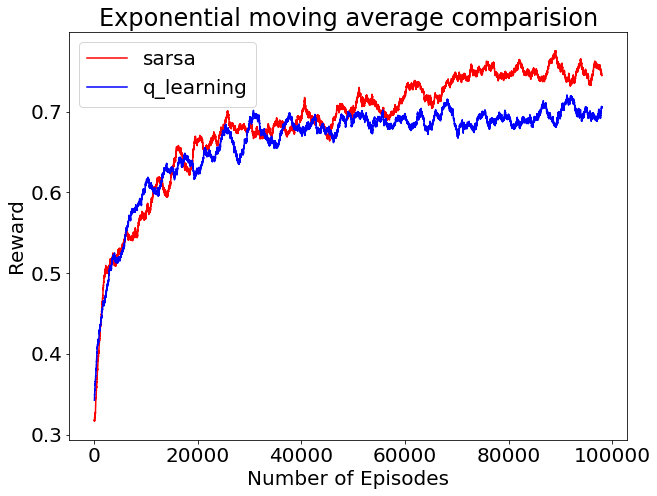

In [26]:
# Plot: Reward per game exponential
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_sarsa, n=2000), 'r', label='sarsa')
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_q, n=2000), 'b', label='q_learning')
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.title("Exponential moving average comparision")
plt.legend()
plt.show()

# The optimal results
To get the best results we achieved (winning in over 99% of the games) use the following setup for training:

In [27]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE THE NEURAL NETWORK...
class Neural_Netork(nn.Module):
    def __init__(self):
        super(Neural_Netork, self).__init__()
        self.fc1 = nn.Linear(N_in, N_h)
        self.out = nn.Linear(N_h, N_a)
        
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        action = self.out(x)
        return action


In [28]:
# HYPERPARAMETERS OPTIMAL(FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
memory_size = 2000 # THE SIZE OF THE MEMORY
reward_draw = -1  # THE REWARD FOR A DRAW
reward_check = 1 # THE REWARD FOR A CHECK

In [29]:
# SAVING VARIABLES
R_save_sarsa_optimal = np.zeros([N_episodes, 1])
N_moves_save_sarsa_optimal = np.zeros([N_episodes, 1])
Training_time_per_episode_sarsa_optimal = np.zeros([N_episodes, 1])

# PRINT AVERAGE REWARD EVERY NUMBER OF EPISODES
print_every = 500

In [30]:
env = Chess_Env(4)
agent_sarsa_optimal = ChessAgent()

print(f"Average rewards for every {print_every} episodes:")
print('---------------------------------------')
for n in range(N_episodes):

    if n % print_every == 0 and n != 0:
      print('Average reward:',np.mean(R_save_sarsa_optimal[n-print_every:n]),'Number of steps: ',np.mean(N_moves_save_sarsa_optimal[n-print_every:n]), 'Training time: ',np.mean(Training_time_per_episode_sarsa_optimal[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game(reward_draw=reward_draw, reward_check=reward_check)      ## INITIALISE GAME

    action1 = agent_sarsa_optimal.choose_action(X, allowed_a, epsilon_f)

    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action1)

        if agent_sarsa_optimal.memory_counter >= memory_size:
              agent_sarsa_optimal.train_sarsa()  

        if Done==1: 
          action2 = 0  # just to add something to the memory       
          agent_sarsa_optimal.store_transition_sarsa(X, action1, action2, R, X_next, Done)
          R_save_sarsa_optimal[n]=np.copy(R)
          N_moves_save_sarsa_optimal[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa_optimal[n] = (abs(start-end)/1000)
          break
        
        action2 = agent_sarsa_optimal.choose_action(X_next, allowed_a_next, epsilon_f)
        
        agent_sarsa_optimal.store_transition_sarsa(X, action1, action2, R, X_next, Done)

       

        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
          R_save_sarsa_optimal[n]=np.copy(R)
          N_moves_save_sarsa_optimal[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa_optimal[n] = (abs(start-end)/1000)
          break

        # IF THE EPISODE IS NOT OVER, ADD REWARD
        else:
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        action1=np.copy(action2)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

Average rewards for every 500 episodes:
---------------------------------------
Average reward: -0.52 Number of steps:  7.416 Training time:  8.878459882736206e-05
Average reward: 0.12 Number of steps:  8.2 Training time:  9.882355880737305e-05
Average reward: 0.32 Number of steps:  6.684 Training time:  7.801853704452514e-05
Average reward: 0.468 Number of steps:  5.118 Training time:  4.523299503326416e-05
Average reward: 0.56 Number of steps:  3.872 Training time:  4.5356547355651856e-05
Average reward: 0.684 Number of steps:  3.51 Training time:  3.22083625793457e-05
Average reward: 0.704 Number of steps:  3.292 Training time:  3.1439657211303704e-05
Average reward: 0.756 Number of steps:  3.478 Training time:  3.14911847114563e-05
Average reward: 0.836 Number of steps:  3.398 Training time:  3.123385953903198e-05
Average reward: 0.812 Number of steps:  3.112 Training time:  3.039249515533447e-05
Average reward: 0.816 Number of steps:  3.156 Training time:  2.861391496658325e-05
Av

In [31]:
size_board = 4
env=Chess_Env(size_board)



wins = 0
steps = []

for k in range(10000):

  S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME
  Done = 0
  i = 0

  while Done==0:
      i += 1
      a_agent=agent_sarsa_optimal.choose_action(X, allowed_a, 0)         # MAKE AN ACTION
      S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT

      if Done == 1:
        steps.append(i)
        wins += 1
        break
          
# Yes the optimal agent wins in more than 99% of cases!
print("*********************************")
print(f"Best performance: number of wins in 10000 games: {wins}")
print(f"Average number of steps: {mean(steps)}")
print("*********************************")

*********************************
Best performance: number of wins in 10000 games: 10000
Average number of steps: 2.333
*********************************
